#GoogLeNet 실습 <br>
해당 실습파일은 'GoogLeNet : Going deeper with convolutions' 논문에 나온 모델을 <br>
구현해본 것입니다! <br>
출처: https://github.com/Devlee247/PyTorch-Implementations/blob/master/CNN/GoogLeNet.ipynb


##필요 package download



In [ ]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from torchsummary import summary


image를 보여주는 함수 생성

In [ ]:
def custom_imshow(img):
    img = img.numpy()
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()

##dataset download & dataloader setting

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize(224),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 64

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

#dataset은 cifar-10 data를 사용할 예정.
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:03<00:00, 48231929.92it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


cifar-10 확인

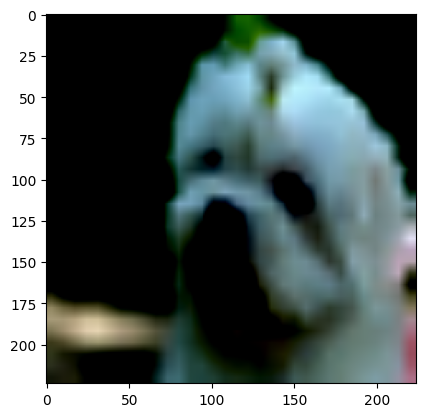

dog


In [ ]:
sample_num = 919

custom_imshow(trainset[sample_num][0])
print(classes[trainset[sample_num][1]])

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

##Inception Module

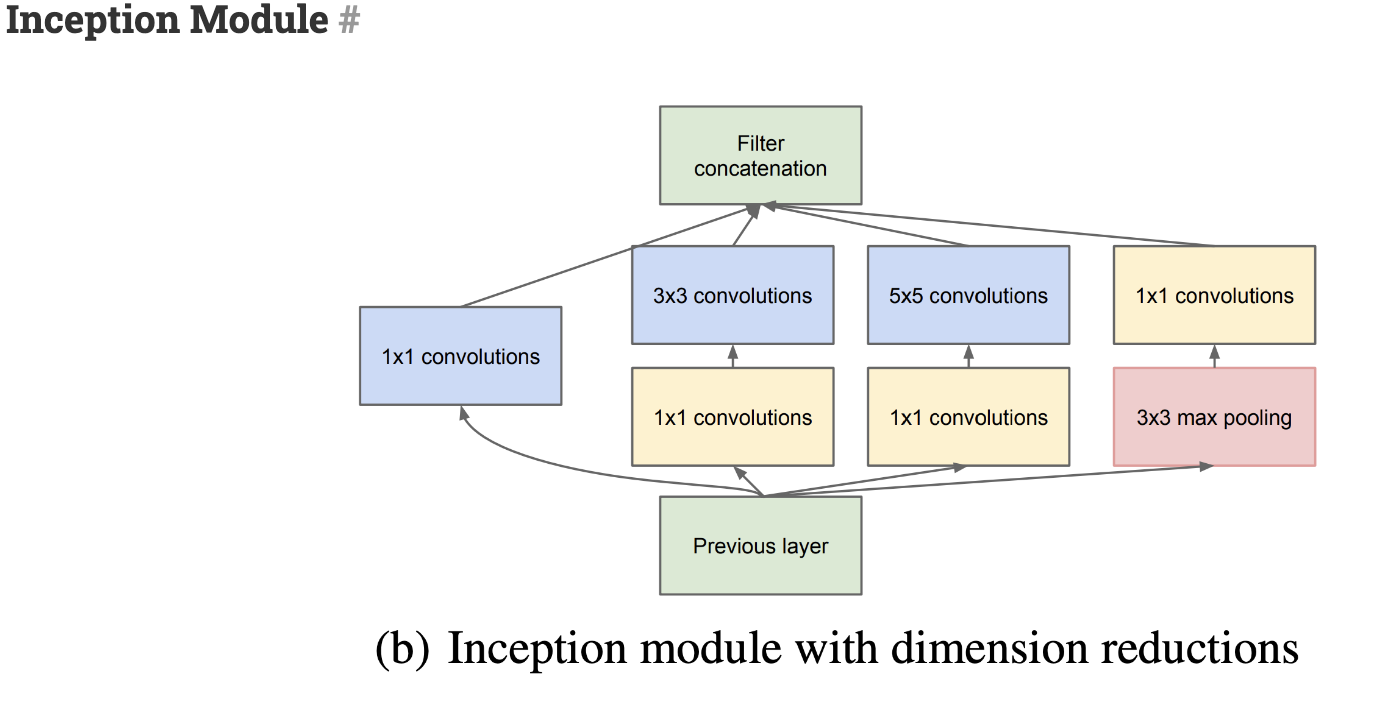

In [ ]:
class InceptionModule(nn.Module):
    def __init__(self, in_channels, ch1x1, ch3x3_red, ch3x3, ch5x5_red, ch5x5, pool):
        super(InceptionModule, self).__init__()

        self.conv1x1 = nn.Conv2d(in_channels, ch1x1, kernel_size=1)

        self.conv3x3 = nn.Sequential(
            BaseConv2d(in_channels, ch3x3_red, kernel_size=1),
            BaseConv2d(ch3x3_red, ch3x3, kernel_size=3, padding=1)
        )

        self.conv5x5 = nn.Sequential(
            BaseConv2d(in_channels, ch5x5_red, kernel_size=1),
            BaseConv2d(ch5x5_red, ch5x5, kernel_size=5, padding=2)
        )

        self.pool = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            BaseConv2d(in_channels, pool, kernel_size=1)
        )

    def forward(self, x):
        x1 = self.conv1x1(x)
        x2 = self.conv3x3(x)
        x3 = self.conv5x5(x)
        x4 = self.pool(x)

        return torch.cat([x1, x2, x3, x4], 1)

class BaseConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(BaseConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, **kwargs)
        self.ReLU = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.ReLU(self.conv(x))

##GoogLeNet Model

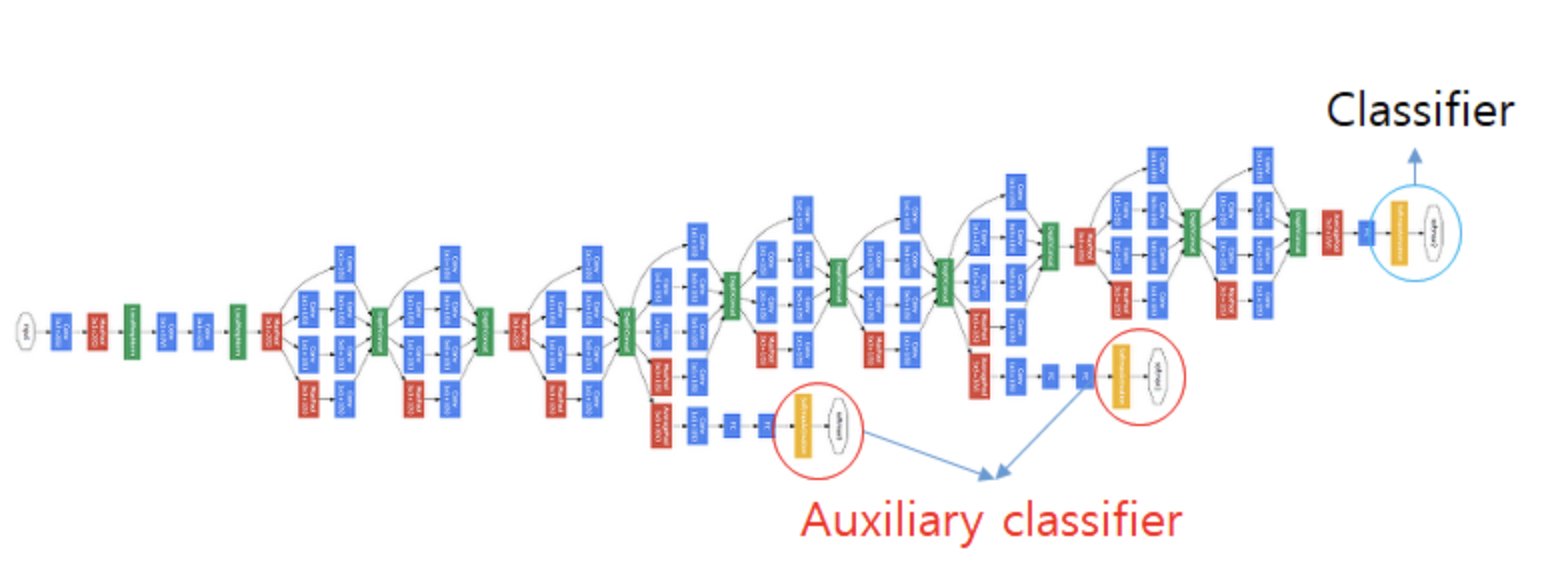 <br>
출처: https://velog.io/@euisuk-chung/%ED%8C%8C%EC%9D%B4%ED%86%A0%EC%B9%98-%ED%8C%8C%EC%9D%B4%ED%86%A0%EC%B9%98%EB%A1%9C-CNN-%EB%AA%A8%EB%8D%B8%EC%9D%84-%EA%B5%AC%ED%98%84%ED%95%B4%EB%B3%B4%EC%9E%90-GoogleNet%ED%8E%B8

In [ ]:
class GoogLeNet(torch.nn.Module):
    def __init__(self, in_channels, num_classes):
        super(GoogLeNet, self).__init__()

        self.training = True

        self.conv1 = nn.Sequential(
            BaseConv2d(in_channels, 64, kernel_size=7, stride=2, padding=3),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.LocalResponseNorm(2)
        )

        self.conv2 = nn.Sequential(
            BaseConv2d(64, 64, kernel_size=1),
            BaseConv2d(64, 192, kernel_size=3, padding=1),
            nn.LocalResponseNorm(2),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        self.inception_3a = InceptionModule(192, 64, 96, 128, 16, 32, 32)
        self.inception_3b = InceptionModule(256, 128, 128, 192, 32, 96, 64)
        self.maxpool_3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.inception_4a = InceptionModule(480, 192, 96, 208, 16, 48, 64)
        self.aux1 = AuxModule(512, num_classes)


        self.inception_4b = InceptionModule(512, 160, 112, 224, 24, 64, 64)
        self.inception_4c = InceptionModule(512, 128, 128, 256, 24, 64, 64)
        self.inception_4d = InceptionModule(512, 112, 144, 288, 32, 64, 64)
        self.aux2 = AuxModule(528, num_classes)

        self.inception_4e = InceptionModule(528, 256, 160, 320, 32, 128, 128)
        self.maxpool_4 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.inception_5a = InceptionModule(832, 256, 160, 320, 32, 128, 128)
        self.inception_5b = InceptionModule(832, 384, 192, 384, 48, 128, 128)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.dropout = nn.Dropout2d(p=0.4)
        self.fc = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)

        x = self.inception_3a(x)
        x = self.inception_3b(x)
        x = self.maxpool_3(x)

        x = self.inception_4a(x)
        if self.training:
            out1 = self.aux1(x)

        x = self.inception_4b(x)
        x = self.inception_4c(x)
        x = self.inception_4d(x)
        if self.training:
            out2 = self.aux2(x)

        x = self.inception_4e(x)
        x = self.maxpool_4(x)

        x = self.inception_5a(x)
        x = self.inception_5b(x)

        x = self.avgpool(x)

        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        if self.training:
             return [x, out1, out2]
        else:
            return x

    def set_train(self):
        self.training = True

    def set_eval(self):
        self.training = False


class AuxModule(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(AuxModule, self).__init__()

        self.avgpool = nn.AdaptiveAvgPool2d((4,4))
        self.conv1 = BaseConv2d(in_channels, 128, kernel_size=1)
        self.fc = nn.Sequential(
            nn.Linear(4*4*128, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.7),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        x = self.avgpool(x)
        x = self.conv1(x)
        x = torch.flatten(x, 1)
        return self.fc(x)


Epoch, parameter 설정 및 summary

In [ ]:
model = GoogLeNet(3,10).cuda()
lr = 0.00001
epochs = 30
#인용한 코드에선 100회였지만, 시간이 오래 걸리는 관계로 30회로 조정했습니다..
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
summary(model, input_size=(3, 224, 224), device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,472
              ReLU-2         [-1, 64, 112, 112]               0
        BaseConv2d-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
 LocalResponseNorm-5           [-1, 64, 56, 56]               0
            Conv2d-6           [-1, 64, 56, 56]           4,160
              ReLU-7           [-1, 64, 56, 56]               0
        BaseConv2d-8           [-1, 64, 56, 56]               0
            Conv2d-9          [-1, 192, 56, 56]         110,784
             ReLU-10          [-1, 192, 56, 56]               0
       BaseConv2d-11          [-1, 192, 56, 56]               0
LocalResponseNorm-12          [-1, 192, 56, 56]               0
        MaxPool2d-13          [-1, 192, 28, 28]               0
           Conv2d-14           [-1, 64,

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Training

In [ ]:
for epoch in range(epochs):
    print("\nEpoch ", epoch)
    # train
    print("\nTrain:")
    model.train()
    model.set_train()
    train_loss = 0
    for i, (images, targets) in enumerate(train_loader):
        images, targets = images.to(device), targets.to(device)

        pred0, pred1, pred2 = model(images)
        loss0 = F.cross_entropy(pred0, targets)
        loss1 = F.cross_entropy(pred1, targets)
        loss2 = F.cross_entropy(pred2, targets)

        loss = loss0 + 0.3 * loss1 + 0.3  * loss2

        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if ((i+1) % (len(train_loader) // 8) == 1) or i+1 == len(train_loader):
            print('[%3d/%3d] | Loss: %.5f'%(i+1, len(train_loader), train_loss/(i+1)))
    # val
    print("\nValidation")
    model.eval()
    model.set_eval()
    val_loss = 0
    correct = 0
    for i, (images, targets) in enumerate(test_loader):
        images, targets = images.to(device), targets.to(device)

        out = model(images)
        loss = F.cross_entropy(out, targets)

        val_loss += loss.item()

        pred = torch.argmax(out, 1)

        correct += (pred==targets).sum().item()



        if ((i+1) % (len(test_loader) // 3) == 1) or i+1 == len(test_loader):
            print('[%3d/%3d] | Loss: %.5f'%(i+1, len(test_loader), val_loss/(i+1)))
    print(f"Accuracy of the network : {100*correct//(len(test_loader)*batch_size)}%")


Epoch  0

Train:


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

[  1/782] | Loss: 3.68365
[ 98/782] | Loss: 3.68459
[195/782] | Loss: 3.68449
[292/782] | Loss: 3.68435
[389/782] | Loss: 3.68241
[486/782] | Loss: 3.65879
[583/782] | Loss: 3.60732
[680/782] | Loss: 3.56523
[777/782] | Loss: 3.52725
[782/782] | Loss: 3.52585

Validation


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

[  1/157] | Loss: 1.92337
[ 53/157] | Loss: 2.03407
[105/157] | Loss: 2.03358
[157/157] | Loss: 2.02457
Accuracy of the network : 25%

Epoch  1

Train:


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

[  1/782] | Loss: 3.27838
[ 98/782] | Loss: 3.24270
[195/782] | Loss: 3.22586
[292/782] | Loss: 3.21021
[389/782] | Loss: 3.19797
[486/782] | Loss: 3.19109
[583/782] | Loss: 3.18263
[680/782] | Loss: 3.17093
[777/782] | Loss: 3.16078
[782/782] | Loss: 3.16022

Validation


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

[  1/157] | Loss: 1.83483
[ 53/157] | Loss: 1.90900
[105/157] | Loss: 1.90795
[157/157] | Loss: 1.90212
Accuracy of the network : 29%

Epoch  2

Train:


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

[  1/782] | Loss: 3.17118
[ 98/782] | Loss: 3.04242
[195/782] | Loss: 3.03957
[292/782] | Loss: 3.02997
[389/782] | Loss: 3.01367
[486/782] | Loss: 2.99797
[583/782] | Loss: 2.98845
[680/782] | Loss: 2.97869
[777/782] | Loss: 2.96897
[782/782] | Loss: 2.96855

Validation


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

[  1/157] | Loss: 1.75455
[ 53/157] | Loss: 1.80091
[105/157] | Loss: 1.80031
[157/157] | Loss: 1.79448
Accuracy of the network : 34%

Epoch  3

Train:


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

[  1/782] | Loss: 2.81382
[ 98/782] | Loss: 2.89706
[195/782] | Loss: 2.87830
[292/782] | Loss: 2.86181
[389/782] | Loss: 2.85512
[486/782] | Loss: 2.84547
[583/782] | Loss: 2.84035
[680/782] | Loss: 2.83502
[777/782] | Loss: 2.82838
[782/782] | Loss: 2.82720

Validation


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

[  1/157] | Loss: 1.67063
[ 53/157] | Loss: 1.71622
[105/157] | Loss: 1.71279
[157/157] | Loss: 1.71258
Accuracy of the network : 37%

Epoch  4

Train:


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

[  1/782] | Loss: 2.87305
[ 98/782] | Loss: 2.77225
[195/782] | Loss: 2.77694
[292/782] | Loss: 2.78647
[389/782] | Loss: 2.77614
[486/782] | Loss: 2.77286
[583/782] | Loss: 2.76516
[680/782] | Loss: 2.75818
[777/782] | Loss: 2.75140
[782/782] | Loss: 2.75129

Validation


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

[  1/157] | Loss: 1.65158
[ 53/157] | Loss: 1.65933
[105/157] | Loss: 1.66052
[157/157] | Loss: 1.65741
Accuracy of the network : 39%

Epoch  5

Train:


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

[  1/782] | Loss: 2.71212
[ 98/782] | Loss: 2.69232
[195/782] | Loss: 2.70996
[292/782] | Loss: 2.71774
[389/782] | Loss: 2.71411
[486/782] | Loss: 2.70394
[583/782] | Loss: 2.69379
[680/782] | Loss: 2.68907
[777/782] | Loss: 2.69046
[782/782] | Loss: 2.68997

Validation


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

[  1/157] | Loss: 1.59208
[ 53/157] | Loss: 1.61862
[105/157] | Loss: 1.62280
[157/157] | Loss: 1.62206
Accuracy of the network : 40%

Epoch  6

Train:


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

[  1/782] | Loss: 2.82702
[ 98/782] | Loss: 2.65490
[195/782] | Loss: 2.65744
[292/782] | Loss: 2.65050
[389/782] | Loss: 2.64536
[486/782] | Loss: 2.64380
[583/782] | Loss: 2.64438
[680/782] | Loss: 2.64141
[777/782] | Loss: 2.64235
[782/782] | Loss: 2.64189

Validation


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

[  1/157] | Loss: 1.60196
[ 53/157] | Loss: 1.59460
[105/157] | Loss: 1.60282
[157/157] | Loss: 1.60156
Accuracy of the network : 40%

Epoch  7

Train:


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

[  1/782] | Loss: 2.66773
[ 98/782] | Loss: 2.59833
[195/782] | Loss: 2.61507
[292/782] | Loss: 2.61364
[389/782] | Loss: 2.61288
[486/782] | Loss: 2.60716
[583/782] | Loss: 2.61192
[680/782] | Loss: 2.60552
[777/782] | Loss: 2.60072
[782/782] | Loss: 2.59986

Validation


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

[  1/157] | Loss: 1.54418
[ 53/157] | Loss: 1.56060
[105/157] | Loss: 1.56401
[157/157] | Loss: 1.56609
Accuracy of the network : 41%

Epoch  8

Train:


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

[  1/782] | Loss: 2.73490
[ 98/782] | Loss: 2.57948
[195/782] | Loss: 2.57314
[292/782] | Loss: 2.57021
[389/782] | Loss: 2.56575
[486/782] | Loss: 2.56880
[583/782] | Loss: 2.56591
[680/782] | Loss: 2.56445
[777/782] | Loss: 2.56749
[782/782] | Loss: 2.56696

Validation


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

[  1/157] | Loss: 1.52424
[ 53/157] | Loss: 1.53889
[105/157] | Loss: 1.54576
[157/157] | Loss: 1.54498
Accuracy of the network : 42%

Epoch  9

Train:


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

[  1/782] | Loss: 2.60372
[ 98/782] | Loss: 2.54878
[195/782] | Loss: 2.54646
[292/782] | Loss: 2.54411
[389/782] | Loss: 2.53914
[486/782] | Loss: 2.54056
[583/782] | Loss: 2.54089
[680/782] | Loss: 2.53859
[777/782] | Loss: 2.53356
[782/782] | Loss: 2.53397

Validation


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

[  1/157] | Loss: 1.49117
[ 53/157] | Loss: 1.52025
[105/157] | Loss: 1.52613
[157/157] | Loss: 1.52643
Accuracy of the network : 43%

Epoch  10

Train:


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

[  1/782] | Loss: 2.60055
[ 98/782] | Loss: 2.51184
[195/782] | Loss: 2.50532
[292/782] | Loss: 2.50252
[389/782] | Loss: 2.49972
[486/782] | Loss: 2.49754
[583/782] | Loss: 2.50144
[680/782] | Loss: 2.50123
[777/782] | Loss: 2.50204
[782/782] | Loss: 2.50235

Validation


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

[  1/157] | Loss: 1.49918
[ 53/157] | Loss: 1.50490
[105/157] | Loss: 1.51031
[157/157] | Loss: 1.51099
Accuracy of the network : 43%

Epoch  11

Train:


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

[  1/782] | Loss: 2.30745
[ 98/782] | Loss: 2.48222
[195/782] | Loss: 2.47296
[292/782] | Loss: 2.48041
[389/782] | Loss: 2.48023
[486/782] | Loss: 2.48014
[583/782] | Loss: 2.47908
[680/782] | Loss: 2.47585
[777/782] | Loss: 2.47467
[782/782] | Loss: 2.47455

Validation


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

[  1/157] | Loss: 1.42204
[ 53/157] | Loss: 1.48808
[105/157] | Loss: 1.50050
[157/157] | Loss: 1.49988
Accuracy of the network : 44%

Epoch  12

Train:


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

[  1/782] | Loss: 2.15614
[ 98/782] | Loss: 2.46735
[195/782] | Loss: 2.47878
[292/782] | Loss: 2.47463
[389/782] | Loss: 2.46264
[486/782] | Loss: 2.46086
[583/782] | Loss: 2.45541
[680/782] | Loss: 2.45314
[777/782] | Loss: 2.44754
[782/782] | Loss: 2.44819

Validation


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

[  1/157] | Loss: 1.49878
[ 53/157] | Loss: 1.46419
[105/157] | Loss: 1.47672
[157/157] | Loss: 1.47532
Accuracy of the network : 45%

Epoch  13

Train:


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

[  1/782] | Loss: 2.23522
[ 98/782] | Loss: 2.39318
[195/782] | Loss: 2.41112
[292/782] | Loss: 2.41807
[389/782] | Loss: 2.41865
[486/782] | Loss: 2.41530
[583/782] | Loss: 2.41854
[680/782] | Loss: 2.42142
[777/782] | Loss: 2.42231
[782/782] | Loss: 2.42155

Validation


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

[  1/157] | Loss: 1.46447
[ 53/157] | Loss: 1.47906
[105/157] | Loss: 1.49311
[157/157] | Loss: 1.48850
Accuracy of the network : 45%

Epoch  14

Train:


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

[  1/782] | Loss: 2.41806
[ 98/782] | Loss: 2.41685
[195/782] | Loss: 2.41264
[292/782] | Loss: 2.40661
[389/782] | Loss: 2.40208
[486/782] | Loss: 2.39972
[583/782] | Loss: 2.39721
[680/782] | Loss: 2.40055
[777/782] | Loss: 2.39749
[782/782] | Loss: 2.39699

Validation


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

[  1/157] | Loss: 1.43437
[ 53/157] | Loss: 1.42682
[105/157] | Loss: 1.43633
[157/157] | Loss: 1.43822
Accuracy of the network : 47%

Epoch  15

Train:


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

[  1/782] | Loss: 2.57652
[ 98/782] | Loss: 2.36372
[195/782] | Loss: 2.35943
[292/782] | Loss: 2.36340
[389/782] | Loss: 2.36674
[486/782] | Loss: 2.36691
[583/782] | Loss: 2.36840
[680/782] | Loss: 2.37148
[777/782] | Loss: 2.36870
[782/782] | Loss: 2.36887

Validation


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

[  1/157] | Loss: 1.41734
[ 53/157] | Loss: 1.42650
[105/157] | Loss: 1.43992
[157/157] | Loss: 1.43878
Accuracy of the network : 46%

Epoch  16

Train:


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

[  1/782] | Loss: 2.39735
[ 98/782] | Loss: 2.37248
[195/782] | Loss: 2.36018
[292/782] | Loss: 2.35107
[389/782] | Loss: 2.34831
[486/782] | Loss: 2.34095
[583/782] | Loss: 2.33902
[680/782] | Loss: 2.33939
[777/782] | Loss: 2.33815
[782/782] | Loss: 2.33740

Validation


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

[  1/157] | Loss: 1.36503
[ 53/157] | Loss: 1.38955
[105/157] | Loss: 1.39993
[157/157] | Loss: 1.40272
Accuracy of the network : 47%

Epoch  17

Train:


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

[  1/782] | Loss: 2.40680
[ 98/782] | Loss: 2.33338
[195/782] | Loss: 2.32273
[292/782] | Loss: 2.32099
[389/782] | Loss: 2.31681
[486/782] | Loss: 2.32147
[583/782] | Loss: 2.32042
[680/782] | Loss: 2.31313
[777/782] | Loss: 2.31468
[782/782] | Loss: 2.31473

Validation


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

[  1/157] | Loss: 1.37896
[ 53/157] | Loss: 1.39108
[105/157] | Loss: 1.40655
[157/157] | Loss: 1.40684
Accuracy of the network : 48%

Epoch  18

Train:


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

[  1/782] | Loss: 2.09437
[ 98/782] | Loss: 2.29666
[195/782] | Loss: 2.29831
[292/782] | Loss: 2.29420
[389/782] | Loss: 2.28890
[486/782] | Loss: 2.29350
[583/782] | Loss: 2.28857
[680/782] | Loss: 2.28618
[777/782] | Loss: 2.28752
[782/782] | Loss: 2.28731

Validation


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

[  1/157] | Loss: 1.33846
[ 53/157] | Loss: 1.37644
[105/157] | Loss: 1.38572
[157/157] | Loss: 1.38697
Accuracy of the network : 48%

Epoch  19

Train:


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

[  1/782] | Loss: 2.33680
[ 98/782] | Loss: 2.28286
[195/782] | Loss: 2.28184
[292/782] | Loss: 2.27370
[389/782] | Loss: 2.27612
[486/782] | Loss: 2.26687
[583/782] | Loss: 2.26640
[680/782] | Loss: 2.26603
[777/782] | Loss: 2.26346
[782/782] | Loss: 2.26378

Validation


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

[  1/157] | Loss: 1.41350
[ 53/157] | Loss: 1.39007
[105/157] | Loss: 1.40388
[157/157] | Loss: 1.40260
Accuracy of the network : 48%

Epoch  20

Train:


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

[  1/782] | Loss: 2.43328
[ 98/782] | Loss: 2.24876
[195/782] | Loss: 2.24768
[292/782] | Loss: 2.24632
[389/782] | Loss: 2.24089
[486/782] | Loss: 2.24055
[583/782] | Loss: 2.24893
[680/782] | Loss: 2.24233
[777/782] | Loss: 2.23713
[782/782] | Loss: 2.23767

Validation


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

[  1/157] | Loss: 1.34522
[ 53/157] | Loss: 1.32135
[105/157] | Loss: 1.32998
[157/157] | Loss: 1.33549
Accuracy of the network : 51%

Epoch  21

Train:


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

[  1/782] | Loss: 2.43831
[ 98/782] | Loss: 2.23772
[195/782] | Loss: 2.22293
[292/782] | Loss: 2.21646
[389/782] | Loss: 2.22246
[486/782] | Loss: 2.21800
[583/782] | Loss: 2.21846
[680/782] | Loss: 2.21529
[777/782] | Loss: 2.21369
[782/782] | Loss: 2.21411

Validation


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

[  1/157] | Loss: 1.26789
[ 53/157] | Loss: 1.31407
[105/157] | Loss: 1.32579
[157/157] | Loss: 1.32710
Accuracy of the network : 50%

Epoch  22

Train:


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

[  1/782] | Loss: 1.87561
[ 98/782] | Loss: 2.17032
[195/782] | Loss: 2.19944
[292/782] | Loss: 2.20587
[389/782] | Loss: 2.21091
[486/782] | Loss: 2.20612
[583/782] | Loss: 2.20413
[680/782] | Loss: 2.20240
[777/782] | Loss: 2.20145
[782/782] | Loss: 2.20122

Validation


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

[  1/157] | Loss: 1.34366
[ 53/157] | Loss: 1.32128
[105/157] | Loss: 1.33433
[157/157] | Loss: 1.34114
Accuracy of the network : 51%

Epoch  23

Train:


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

[  1/782] | Loss: 2.17740
[ 98/782] | Loss: 2.15793
[195/782] | Loss: 2.17351
[292/782] | Loss: 2.17650
[389/782] | Loss: 2.17961
[486/782] | Loss: 2.17820
[583/782] | Loss: 2.17412
[680/782] | Loss: 2.17773
[777/782] | Loss: 2.17768
[782/782] | Loss: 2.17837

Validation


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

[  1/157] | Loss: 1.30215
[ 53/157] | Loss: 1.32693
[105/157] | Loss: 1.34398
[157/157] | Loss: 1.34482
Accuracy of the network : 50%

Epoch  24

Train:


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

[  1/782] | Loss: 2.15676
[ 98/782] | Loss: 2.17228
[195/782] | Loss: 2.17820
[292/782] | Loss: 2.18102
[389/782] | Loss: 2.18140
[486/782] | Loss: 2.16934
[583/782] | Loss: 2.16596
[680/782] | Loss: 2.16130
[777/782] | Loss: 2.15638
[782/782] | Loss: 2.15600

Validation


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

[  1/157] | Loss: 1.26844
[ 53/157] | Loss: 1.27747
[105/157] | Loss: 1.29156
[157/157] | Loss: 1.29337
Accuracy of the network : 52%

Epoch  25

Train:


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

[  1/782] | Loss: 2.38216
[ 98/782] | Loss: 2.12111
[195/782] | Loss: 2.12284
[292/782] | Loss: 2.13071
[389/782] | Loss: 2.13695
[486/782] | Loss: 2.13752
[583/782] | Loss: 2.13642
[680/782] | Loss: 2.13631
[777/782] | Loss: 2.13745
[782/782] | Loss: 2.13822

Validation


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

[  1/157] | Loss: 1.21321
[ 53/157] | Loss: 1.25411
[105/157] | Loss: 1.26450
[157/157] | Loss: 1.27005
Accuracy of the network : 53%

Epoch  26

Train:


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

[  1/782] | Loss: 2.01329
[ 98/782] | Loss: 2.12846
[195/782] | Loss: 2.13815
[292/782] | Loss: 2.13790
[389/782] | Loss: 2.12948
[486/782] | Loss: 2.12791
[583/782] | Loss: 2.12805
[680/782] | Loss: 2.12401
[777/782] | Loss: 2.12321
[782/782] | Loss: 2.12335

Validation


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

[  1/157] | Loss: 1.22544
[ 53/157] | Loss: 1.27676
[105/157] | Loss: 1.28924
[157/157] | Loss: 1.29303
Accuracy of the network : 52%

Epoch  27

Train:


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

[  1/782] | Loss: 1.90106
[ 98/782] | Loss: 2.11776
[195/782] | Loss: 2.11179
[292/782] | Loss: 2.10970
[389/782] | Loss: 2.09904
[486/782] | Loss: 2.10146
[583/782] | Loss: 2.09892
[680/782] | Loss: 2.10083
[777/782] | Loss: 2.10029
[782/782] | Loss: 2.10125

Validation


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

[  1/157] | Loss: 1.21504
[ 53/157] | Loss: 1.24921
[105/157] | Loss: 1.25945
[157/157] | Loss: 1.26413
Accuracy of the network : 53%

Epoch  28

Train:


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

[  1/782] | Loss: 2.13002
[ 98/782] | Loss: 2.08881
[195/782] | Loss: 2.09757
[292/782] | Loss: 2.08552
[389/782] | Loss: 2.09140
[486/782] | Loss: 2.09114
[583/782] | Loss: 2.08893
[680/782] | Loss: 2.08831
[777/782] | Loss: 2.08641
[782/782] | Loss: 2.08552

Validation


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

[  1/157] | Loss: 1.15699
[ 53/157] | Loss: 1.22873
[105/157] | Loss: 1.24281
[157/157] | Loss: 1.24786
Accuracy of the network : 54%

Epoch  29

Train:


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

[  1/782] | Loss: 2.03099
[ 98/782] | Loss: 2.06204
[195/782] | Loss: 2.07976
[292/782] | Loss: 2.07745
[389/782] | Loss: 2.06995
[486/782] | Loss: 2.07021
[583/782] | Loss: 2.06641
[680/782] | Loss: 2.06637
[777/782] | Loss: 2.06205
[782/782] | Loss: 2.06162

Validation


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

[  1/157] | Loss: 1.16627
[ 53/157] | Loss: 1.22617
[105/157] | Loss: 1.23928
[157/157] | Loss: 1.24409
Accuracy of the network : 54%


현재 도출된 최종적인 accuracy는 54%이지만, 실제 epoch를 100회 이상으로 실시하면 **70~72%**까지 accuracy가 상승합니다! <br>
(아래 사진은 결과창의 캡처본입니다.)

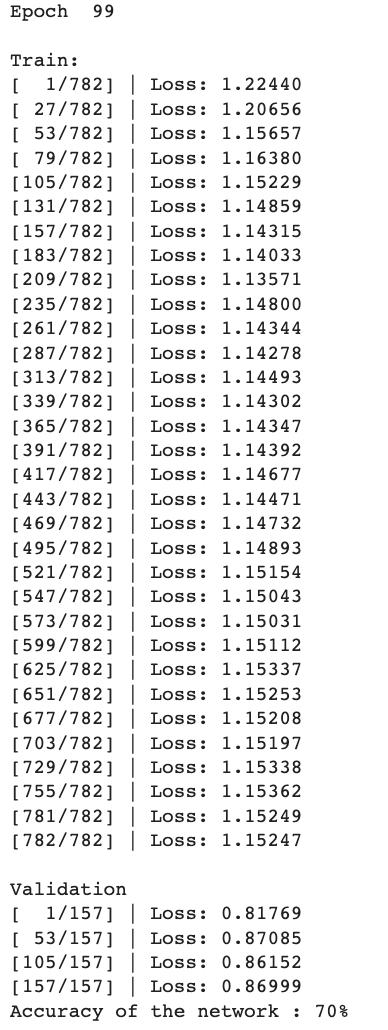

자료 출처:<br>
  1. https://www.cv-foundation.org/openaccess/content_cvpr_2015/html/Szegedy_Going_Deeper_With_2015_CVPR_paper.html <br>

  2. https://velog.io/@euisuk-chung%ED%8C%8C%EC%9D%B4%ED%86%A0%EC%B9%98-%ED%8C%8C%EC%9D%B4%ED%86%A0%EC%B9%98%EB%A1%9C-CNN-%EB%AA%A8%EB%8D%B8%EC%9D%84-%EA%B5%AC%ED%98%84%ED%95%B4%EB%B3%B4%EC%9E%90-GoogleNet%ED%8E%B8 <br>
  3. https://roytravel.tistory.com/338